In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
! pip install sentencepiece

import sentencepiece as spm
import unicodedata
import re
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import os
import io
import time

!pip install japanize-matplotlib
import japanize_matplotlib
tf.enable_eager_execution()

     |████████████████████████████████| 1.0MB 2.7MB/s 
     |████████████████████████████████| 4.1MB 2.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=6dfb822be916fb8dabada5931f6d85e259c7cc658d536a7cd133d221b591d2e1
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib


In [0]:
# load txt file
def load_def(path):
    # open a txt file as read only
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    return lines

In [0]:
# create each languages list
def create_lang_list(num_example):
    # load txt file
    lines = load_def("/content/drive/My Drive/Colab Notebooks/raw.txt")

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_example]]

    return zip(*word_pairs)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# translate English to Japanese

In [0]:
# convert unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFC', s)
                    if unicodedata.category(c) != 'Mn')

# preprocess
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # create a space between word and the punctuation
    w = re.sub(r"([?!¿.,。])", r" \1 ", w)
    # replacing everything with space except(a-z, A-Z, ".",  "?",  "!",  ",", "-", "ー", , "。", "Kanji", "Katakana", "Hiragana")
    w = re.sub(r"[^a-zA-Z\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?.!,。¿\-/ {1,}/]+",  " ", w)
    w = w.rstrip().strip()
    
    # add a sos and eos token to the sentence
    # model know when to start and eos

    w = "<sos> " + w + " <eos>"
    return w

In [8]:
# check lang list
en, ja = create_lang_list(10)
print(en[:3])
print(ja[:3])

('<sos> you are back ,  aren t you ,  harold ? <eos>', '<sos> my opponent is shark . <eos>', '<sos> this is one thing in exchange for another . <eos>')
('<sos> あなたは戻ったのね ハロルド ? <eos>', '<sos> 俺の相手は シャークだ 。 <eos>', '<sos> 引き換えだ ある事とある物の <eos>')


In [0]:
# return max length
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
    # vectorize a text corpus
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters=' ')

    # updates internal vocabulary based on a list of texts
    # e.g. "[this place is good ]"→{this:2, place:3, is:1, good:4} "
    lang_tokenizer.fit_on_texts(lang)

    # Transforms each text in texts to a sequence of integers.
    # e.g. this place is good → [[2, 3, 1, 4]]
    tensor = lang_tokenizer.texts_to_sequences(lang)

    # transform a list of num sample into a 2D Numpy array of shape 
    # Fixed length because length of sequence of integers are different
    # return (len(sequences), maxlen)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')
    return tensor, lang_tokenizer

In [11]:
# example
tokenize(['this place is good', "こんにちは 今日は いい天気", "today is so cold"])

(array([[ 2,  3,  1,  4],
        [ 5,  6,  7,  0],
        [ 8,  1,  9, 10]], dtype=int32),
 <keras_preprocessing.text.Tokenizer at 0x7fb6d94bb588>)

In [0]:
# create a clean input, output pairs
def load_dataset(num_example):
    input_lang, target_lang= create_lang_list(num_example)
    print(target_lang[:5])

    # input_tensor, target_tensor: 2d numpy array
    # input_lang_tokenize, target_lang_tokenize: word dictionary
    input_tensor, input_lang_tokenize = tokenize(input_lang)
    target_tensor, target_lang_tokenize = tokenize(target_lang)

    return input_tensor, target_tensor, input_lang_tokenize, target_lang_tokenize

In [13]:
# limit datasize for test
num_example = 30000
# get data
input_tensor, target_tensor, input_lang, target_lang = load_dataset(num_example)
# Calculate max_length of the target tensors
max_length_target, max_length_input = max_length(target_tensor), max_length(input_tensor)

('<sos> あなたは戻ったのね ハロルド ? <eos>', '<sos> 俺の相手は シャークだ 。 <eos>', '<sos> 引き換えだ ある事とある物の <eos>', '<sos> もういいよ ごちそうさま ううん <eos>', '<sos> もう会社には来ないでくれ 電話もするな <eos>')


In [14]:
# create trainnig set and validation set
input_tensor_train, input_tensor_val, \
    target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

# show length
print(len(input_tensor_train), len(input_tensor_val), len(target_tensor_train), len(target_tensor_val))

24000 6000 24000 6000


In [0]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            # Index number assigned to each word
            print("%d----->%s" % (t, lang.index_word[t]))

In [16]:
print("input lang: index to word mapping")
convert(input_lang, input_tensor_train[50])
print("output lang: index to word mapping")
convert(target_lang, target_tensor_train[50])

input lang: index to word mapping
1-----><sos>
20----->we
27----->are
1815----->bullshit
3----->.
2-----><eos>
output lang: index to word mapping
1-----><sos>
5994----->私達はでたらめ
2-----><eos>


In [17]:
# BUFFER_SIZE >= dataset if smaller than dataset can't shuffle equally
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128

# if None steps_per_epoch == mum of dataset
steps_per_epoch = len(input_tensor_train)
embedding_dim = 300
units = 512
vocab_inp_size = len(input_lang.word_index) + 1
print('Total unique words in the input: %s' % len(input_lang.word_index))
vocab_tar_size = len(target_lang.word_index) + 1

# create dataset
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
print(dataset)
# split dataset → (dataset % BATCH_SIZE)
# drop_remainder=True → rounddown
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
# e.g.
for batch in dataset.take(3):
  print([arr.numpy() for arr in batch])
print(dataset)

Total unique words in the input: 16351
<DatasetV1Adapter shapes: ((65,), (20,)), types: (tf.int32, tf.int32)>
[array([[  1,   5,  45, ...,   0,   0,   0],
       [  1, 115,   4, ...,   0,   0,   0],
       [  1,  47, 233, ...,   0,   0,   0],
       ...,
       [  1,   7, 233, ...,   0,   0,   0],
       [  1,  12,  11, ...,   0,   0,   0],
       [  1,  12,  11, ...,   0,   0,   0]], dtype=int32), array([[    1,   144,  1948, ...,     0,     0,     0],
       [    1,  2899,  2900, ...,     0,     0,     0],
       [    1, 30479, 30480, ...,     0,     0,     0],
       ...,
       [    1, 12731,     2, ...,     0,     0,     0],
       [    1, 10704,     2, ...,     0,     0,     0],
       [    1, 12286,     2, ...,     0,     0,     0]], dtype=int32)]
[array([[  1,   7, 131, ...,   0,   0,   0],
       [  1,  68, 111, ...,   0,   0,   0],
       [  1,  20, 127, ...,   0,   0,   0],
       ...,
       [  1, 183,  68, ...,   0,   0,   0],
       [  1, 824, 585, ...,   0,   0,   0],
  

In [23]:
example_input_batch, example_target_batch =  next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(128), Dimension(65)]),
 TensorShape([Dimension(128), Dimension(20)]))

# encoder and decoder model

In [0]:
def load_glove():
    embeddings_dictionary = {}
    glove_file = open("/content/drive/My Drive/glove.6B.300d.txt", encoding="utf-8")
    
    for line in glove_file:
        records = line.split()
        # get each words
        word = records[0]
        # get each vector
        vector_dimensions = asarray(records[1:], dtype="float32")
        # correspond word and vector
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()
        
    num_words = min(num_example, vocab_inp_size)
    embedding_matrix = zeros((num_words, embedding_dim))
    # get input words
    for word, index in input_lang.word_index.items():
        # get input word vector from glove embe dictio 
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embeddings_dictionary, embedding_matrix

In [0]:
embeddings_dictionary, embedding_matrix = load_glove()

In [26]:
# check vector "hello" → both of vector are almost same
print(embeddings_dictionary["today"])

[-0.0088454 -0.17628    0.043939   0.23772    0.13331   -0.038687
 -0.26692    0.1492     0.064416  -1.8906     0.0099097 -0.41216
  0.062824   0.39153    0.50311   -0.47787   -0.23483    0.18752
 -0.025923  -0.14872    0.22798    0.54713    0.53562    0.49984
  0.013786   0.15351    0.32206   -0.2693    -0.066984  -0.056332
  0.30094    0.20396   -0.38506    0.20942   -0.98693    0.085462
  0.0233     0.117      0.032743   0.088524   0.034344   0.14554
 -0.14223    0.29083    0.27747    0.15031    0.015692   0.17876
 -0.11635   -0.16394    0.043047  -0.19685   -0.40872    0.19822
 -0.18383    0.60479    0.11638    0.44498    0.28318   -0.17754
  0.43296   -0.24506    0.17239   -0.24866   -0.057211  -0.29188
  0.089692   0.013031  -0.50086   -0.18129   -0.069083  -0.02771
 -0.26332    0.12949    0.014157  -0.28985    0.31563    0.099121
  0.30825    0.20194   -0.2491    -0.19244   -0.01279    0.0057545
  0.29472    0.60901   -0.53944    0.10326    0.063383   0.40192
 -0.21905   -0.1926

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size, embedding_matrix):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_inp_size, embedding_dim, 
                                                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix))
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                                            return_sequences=True,
                                                            return_state=True,
                                                            recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
        
    def initialize_hidden_state(self):
            return tf.zeros((self.batch_size, self.enc_units))

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, embedding_matrix)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 65, 512)
Encoder Hidden state shape: (batch size, units) (128, 512)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, nuits):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                self.W1(values) +  self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [30]:
attention_layer = BahdanauAttention(10)
attention_result , attention_weights = attention_layer(sample_hidden, sample_output)

print("attention result shape: (batch size, units) {}".format(attention_result.shape))
print("attention weight shape:(batch size, sequence_length, 1) {}".format(attention_weights.shape))

attention result shape: (batch size, units) (128, 512)
attention weight shape:(batch size, sequence_length, 1) (128, 65, 1)


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                                            return_sequences=True,
                                                            return_state=True,
                                                            recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state =  self.gru(x)
                
        # output shape == (batch_size * 1, hidden_size
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output  shape == (batch_size, vocab) 
        x = self.fc(output)
        
        return  x, state, attention_weights

In [32]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _,  _ = decoder(tf.random.uniform((128, 1)),
                                                                        sample_hidden, sample_output)
print("Decoder output  shape:(batch_size, vocab size) {}".format(sample_decoder_output.shape))

Decoder output  shape:(batch_size, vocab size) (128, 43846)


# Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                beta_1=0.9, beta_2=0.999, amsgrad=True)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# Checkpoints

In [0]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# train

In [0]:
@tf.function
def train_step(inp, target, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
         
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_lang.word_index['<sos>']] * BATCH_SIZE, 1)
        
        # teacher forcing - feeding the target as a next input
        for t in range(1, target.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(target[:, t], predictions)
            
            # using teacher forcing
            dec_input  = tf.expand_dims(target[:, t], 1)
        
        batch_loss = (loss / int(target.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        return batch_loss

In [68]:
EPOCHS = 3
# load model
# status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))
for epochs in range(EPOCHS):
    start = time.time()
    
    enc_hidden = encoder.initialize_hidden_state()
    total_loss =  0
     
    for (batch, (inp, target)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, target, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            pass
            # print("epoch {} batch {} loss  {: .4f}".format(epochs + 1, batch, batch_loss.numpy()))
        if (epochs + 1) % 50 == 0:
            pass
        #     print("epoch {} loss {: .4f}".format(epochs + 1, total_loss / steps_per_epoch))
        # print("time taken for 1 epoch {} sec\n".format(time.time() - start))
checkpoint.save(file_prefix = checkpoint_prefix)


'/training_checkpoints/ckpt-4'

In [0]:
def evaluate(sentence):
  
    attention_plot = np.zeros((max_length_target, max_length_input))

    sentence = preprocess_sentence(sentence)
    inputs = [input_lang.word_index[i] for i in sentence.split(' ')]
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_input,
                                                           padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_lang.word_index['<sos>']], 0)

    for t in range(max_length_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_lang.index_word[predicted_id] + ' '

        if target_lang.index_word[predicted_id] == '<eos>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

[1, 28, 2]
Input: <sos> he <eos>
Predicted translation: この体は土に返り <eos> 


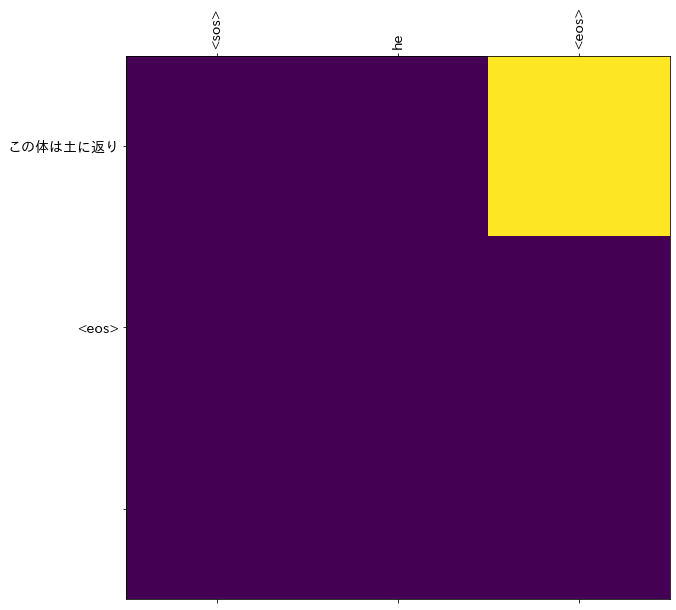

In [72]:
translate(u'he')